In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import GCRCatalogs
from GCR import GCRQuery
import statistics
import os, sys
import healpy as hp
from tqdm.auto import tqdm, trange
import scipy.stats
import FoFCatalogMatching
import pandas as pd
from astropy.coordinates import SkyCoord
from scipy.stats import pearsonr
import warnings

In [2]:
warnings.filterwarnings('ignore')

# cosmoDC2, DC2objects and Filters

In [3]:
mag_filters = [
    'mag_i_cModel < 26.5', 'mag_i_cModel > 18',
    (np.isfinite, 'mag_i_cModel')
]
truth_mag_filters = (['mag_i<28','mag_i>18',(np.isfinite, 'mag_i')]) #larger cut to ensure matching between faintest objects/galaxies

In [4]:
cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image') #truth catalog
dc2 = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons') #object catalog

In [5]:
object_data = (dc2.get_quantities(['ra', 'dec', 'mag_i_cModel', 'photoz_mean', 'blendedness'],
                                 filters=['extendedness>0', 'clean']+mag_filters,
                                 native_filters=['tract==4026']))

In [6]:
eps = 10/3600 # 10 arcsec
max_ra = np.nanmax(object_data['ra']) + eps
min_ra = np.nanmin(object_data['ra']) - eps
max_dec = np.nanmax(object_data['dec']) + eps
min_dec = np.nanmin(object_data['dec']) - eps
pos_filters = [f'ra >= {min_ra}',f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

In [7]:
quantities = ['galaxy_id', 'ra', 'dec', 'mag_i', 'redshift']
truth_data = (cosmodc2.get_quantities(quantities, filters=truth_mag_filters+pos_filters, 
                                      native_filters=healpix_filter))

In [8]:
print("number of galaxies =", len(truth_data['ra']))
print("number of objects =", len(object_data['ra']))

number of galaxies = 2920943
number of objects = 708875


# FoF algorithm

In [9]:
my_linking_length = 1.2 #linking_lenghts in arcseconds

In [10]:
results = (FoFCatalogMatching.match(catalog_dict={'object':pd.DataFrame(object_data), 
                                                 'galaxy':pd.DataFrame(truth_data)}, linking_lengths=my_linking_length)).to_pandas()

In [11]:
print(results)

         row_index catalog_key  group_id
0                0      object         0
1          2052843      galaxy         0
2                1      object         1
3           488380      galaxy         1
4                2      object         2
...            ...         ...       ...
3629813    2920938      galaxy   2271922
3629814    2920939      galaxy   2271923
3629815    2920940      galaxy   2271924
3629816    2920941      galaxy   2271925
3629817    2920942      galaxy   2271926

[3629818 rows x 3 columns]


Linking length 1.2'' 
Number of groups 2271927 
Number of groups with at least 1 galaxy 2264766 (99.68 %)
Number of groups with at least 1 object 694014 (30.55 %)
Average number of galaxies per group : 1.29 
Average number of objects per group : 0.31


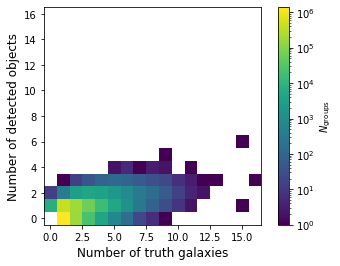

In [12]:
# first we need to know which rows are from the truth catalog and which are from the object
truth_mask = results['catalog_key'] == 'galaxy'
object_mask = ~truth_mask

# then np.bincount will give up the number of id occurrences (like historgram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

#average number of galaxies by groups
ngal_group = len(truth_data['ra'])/n_groups
nobj_group = len(object_data['ra'])/n_groups

print(f'Linking length {my_linking_length}\'\' \nNumber of groups {n_groups} ')
print(f'Number of groups with at least 1 galaxy {len(n_truth[n_truth>0])} ({100*len(n_truth[n_truth>0])/n_groups:.2f} %)')
print(f'Number of groups with at least 1 object {len(n_object[n_object>0])} ({100*len(n_object[n_object>0])/n_groups:.2f} %)')
print(f'Average number of galaxies per group : {ngal_group:.2f} \nAverage number of objects per group : {nobj_group:.2f}')

plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm());
plt.xlabel('Number of truth galaxies', fontsize=12);
plt.ylabel('Number of detected objects', fontsize=12);
plt.colorbar(label=r'$N_{\rm groups}$');
plt.gca().set_aspect('equal');

# Extract the blended groups

In [13]:
results['is_object'] = (results['catalog_key']=='object')

In [14]:
res = results.drop('catalog_key', axis=1)

In [15]:
groups = []

for group_id, rows in res.groupby('group_id'):
    id_gal = list(rows['row_index'][~rows['is_object']])
    id_obj = list(rows['row_index'][rows['is_object']])
    groups.append([id_gal, id_obj])

# Recover the blended systems

In [34]:
def recover_systems(groups, n=1, m=1): # n=number of galaxies, m=number of objects
    sys = []
    for i in range(len(groups)):
        if (len(groups[i][0]), len(groups[i][1])) == (n,m):
            sys.append(groups[i])

In [35]:
sys_2_1 = recover_systems(groups, 2, 1)